In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import xgboost as xgb

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from causalml.inference.meta import BaseTLearner, BaseXLearner, BaseXClassifier, BaseSLearner
import optuna

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

from causalml.metrics import plot_gain, get_cumlift, get_cumgain, plot, auuc_score

# probability distributions & statistical functions
import scipy.stats as stats

# estimating statistical models
import statsmodels.stats.api as sm

# rounding function
from math import ceil

import seaborn as sns
import matplotlib.pyplot as plt

from test_results import valid_results, test_results, score

sns.set_style("whitegrid")

In [124]:
# Restore the default rc parameters
# plt.rcdefaults()

In [125]:
# load in the data
train_data = pd.read_csv('./Training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [126]:
# check number of missing values per column
train_data.isnull().mean()

ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

In [127]:
test_data = pd.read_csv('./Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


# A/B Test

In [128]:
n_treat = train_data.loc[train_data['Promotion'] == 'Yes',:].shape[0]
n_ctrl = train_data.loc[train_data['Promotion'] == 'No',:].shape[0]
n_treat_purch = train_data.loc[train_data['Promotion'] == 'Yes', 'purchase'].sum()
n_ctrl_purch = train_data.loc[train_data['Promotion'] == 'No', 'purchase'].sum()
cr_treat = n_treat_purch / n_treat
cr_ctrl = n_ctrl_purch / n_ctrl
irr = cr_treat - cr_ctrl
nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch

In [129]:
irr

np.float64(0.009454547819772702)

### Sample Size calculation: Power Analysis

Power analysis determines what sample size will ensure a high probability that we correctly reject the Null Hypothesis that there is no difference between the two groups.
Power is affected by several things, however, there are 2 main factors:
1. Overlap: How much overlap there is between the 2 distributions we want to identify with our study
* Effect size
2. Sample Size: the number of each measurements we collect from each group

In [130]:
effect_size = sm.proportion_effectsize(cr_treat, cr_ctrl)    # Calculating effect size based on our baseline rates

required_n = sm.NormalIndPower().solve_power( 
    effect_size,                                               # Effect size for a test comparing two proportions
    power=0.8, 
    alpha=0.05, 
    alternative="larger"
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          
print(required_n)

1616


In [131]:
cr_treat_exp = cr_ctrl + 0.02
cr_treat_exp

np.float64(0.027564619397676075)

In [132]:
effect_size = sm.proportion_effectsize(cr_treat_exp, cr_ctrl)    # Calculating effect size based on our baseline rates

required_n = sm.NormalIndPower().solve_power( 
    effect_size,                                               # Effect size for a test comparing two proportions
    power=0.8, 
    alpha=0.05, 
    alternative="larger"
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          
print(required_n)

487


### Visualization

In [133]:
summary_stats = train_data.groupby('Promotion')['purchase'].agg(['std', 'mean', 'sem', 'sum', 'count'])
summary_stats = summary_stats.reset_index()
summary_stats

,Promotion,std,mean,sem,sum,count
0,No,0.086646,0.007565,0.000422,319,42170
1,Yes,0.129344,0.017019,0.000628,721,42364


In [134]:
print(f"n_ctrl_purch: {n_ctrl_purch}, n_treat_purch: {n_treat_purch}")
print(f"n_ctrl: {n_ctrl}, cr_ctrl: {cr_ctrl}, n_treat: {n_treat}, cr_treat: {cr_treat}")

n_ctrl_purch: 319, n_treat_purch: 721
n_ctrl: 42170, cr_ctrl: 0.007564619397676073, n_treat: 42364, cr_treat: 0.017019167217448776


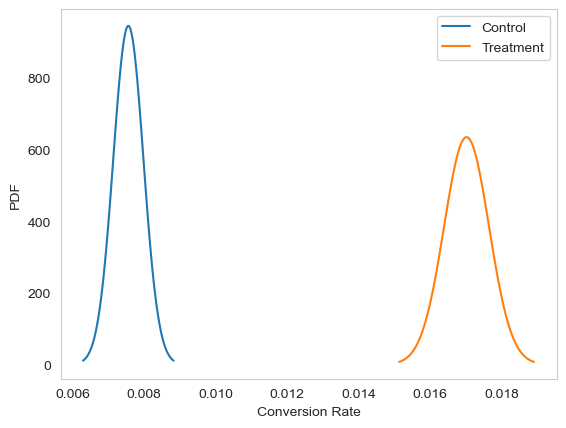

In [135]:
from scipy.stats import norm

# Compute the standard deviations
ctrl_sd = (cr_ctrl * (1 - cr_ctrl) / n_ctrl) ** 0.5
treat_sd = (cr_treat * (1 - cr_treat) / n_treat) ** 0.5

# Create the range of x values
ctrl_line = np.linspace(cr_ctrl - 3 * ctrl_sd, cr_ctrl + 3 * ctrl_sd, 100)
treat_line = np.linspace(cr_treat - 3 * treat_sd, cr_treat + 3 * treat_sd, 100)

# Plot distributions
plt.plot(ctrl_line, norm.pdf(ctrl_line, cr_ctrl, ctrl_sd), label="Control")
plt.plot(treat_line, norm.pdf(treat_line, cr_treat, treat_sd), label="Treatment")

plt.xlabel("Conversion Rate")
plt.ylabel("PDF")
plt.grid()
plt.legend()
plt.show()

### Test for Statistically Significance

In [136]:
count = [n_treat_purch, n_ctrl_purch]
nobs = [n_treat, n_ctrl]

In [137]:
from statsmodels.stats.proportion import proportions_ztest

zstat, pval = proportions_ztest(
    count,
    nobs,
    alternative="larger"
)
zstat, pval

(np.float64(12.468449461599388), np.float64(5.548209627035781e-36))

## EDA

In [138]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [139]:
train_data['Promotion'].value_counts()

Promotion
Yes    42364
No     42170
Name: count, dtype: int64

In [140]:
train_data['purchase'].value_counts()

purchase
0    83494
1     1040
Name: count, dtype: int64

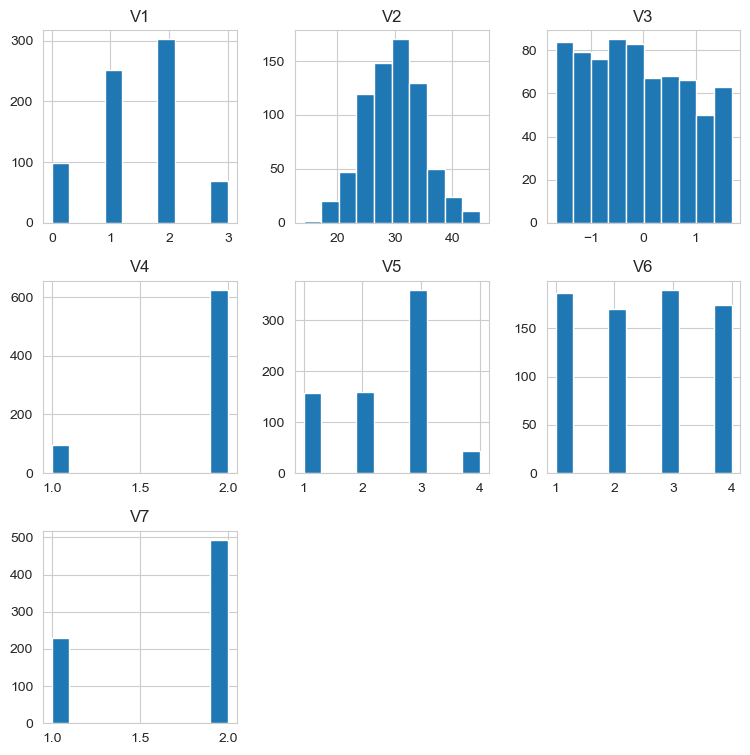

In [141]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(9,9));

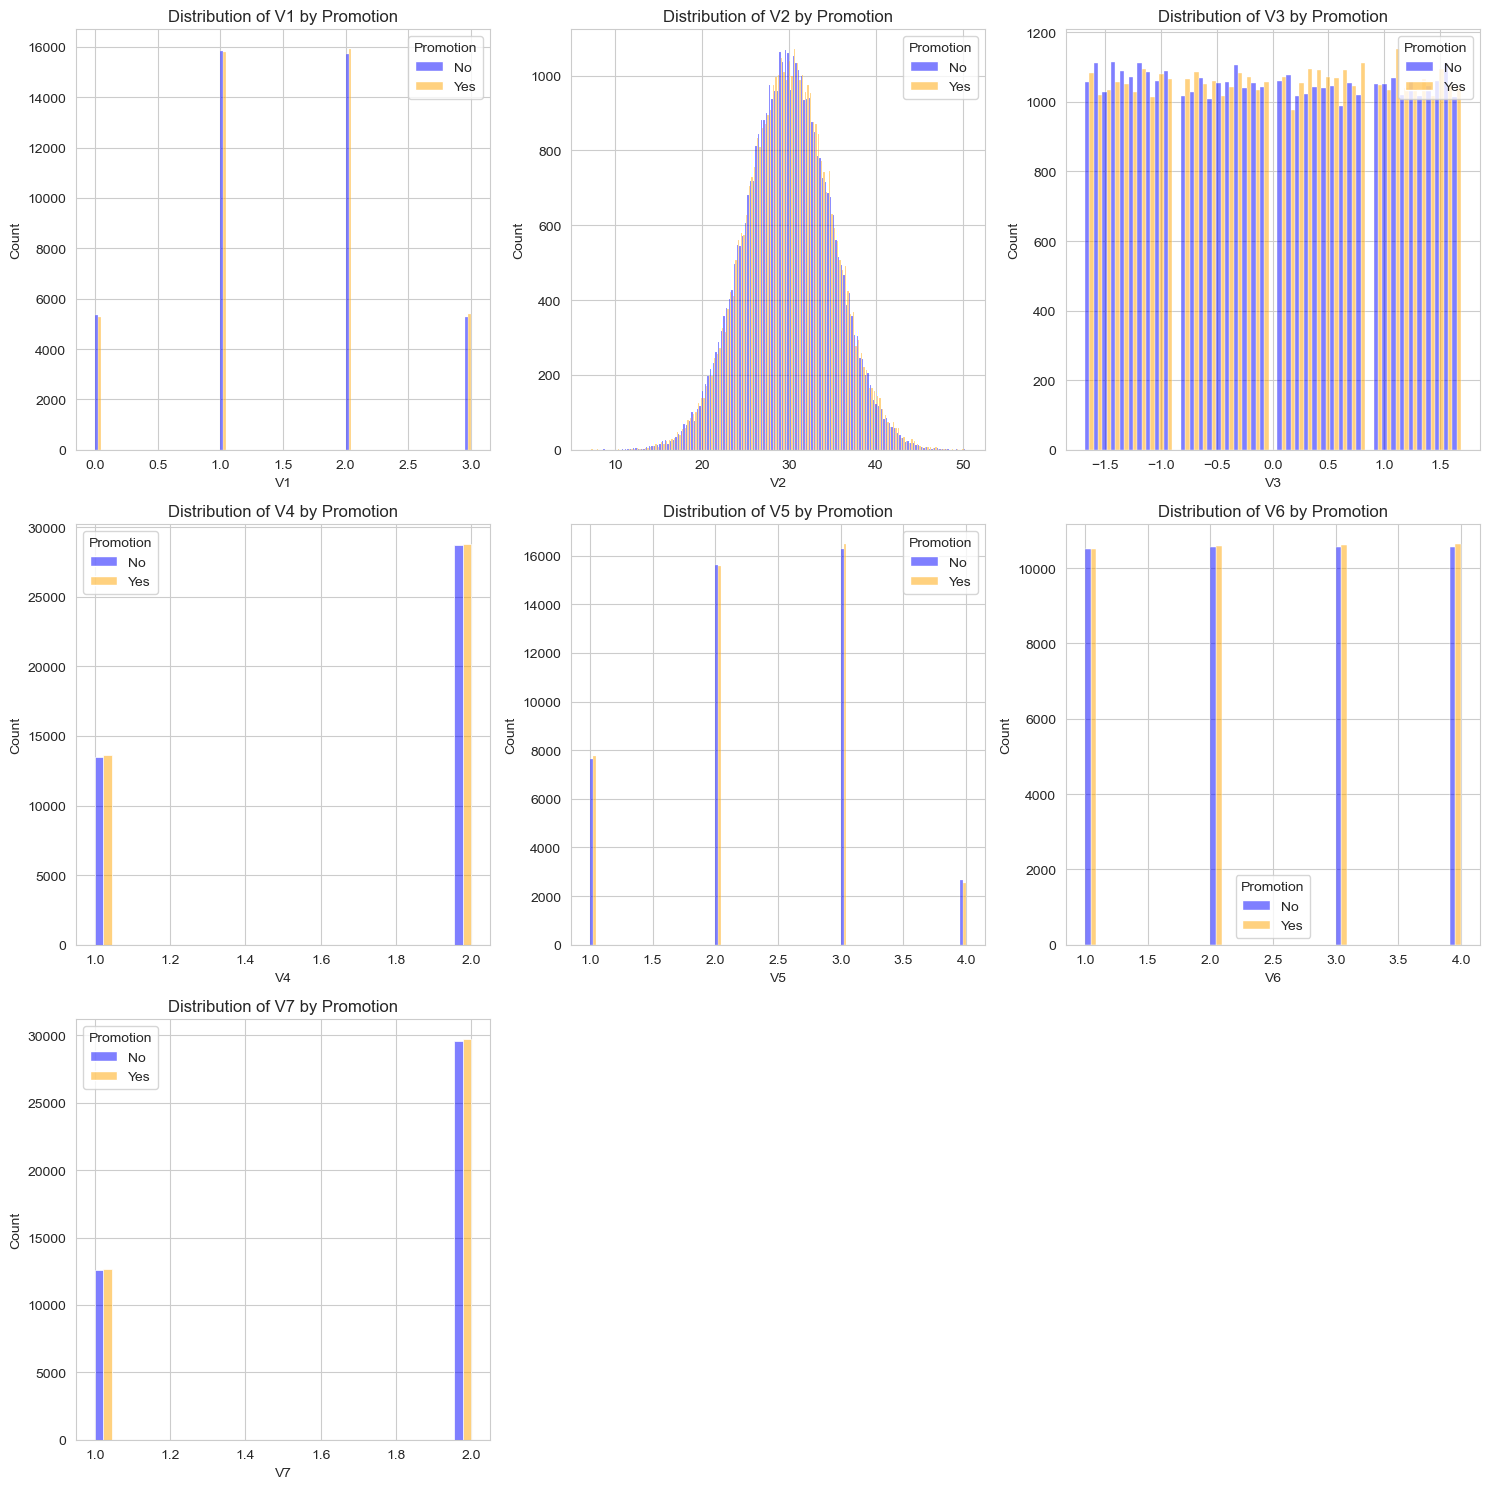

In [142]:
# Define the number of columns for the subplot grid
cols = 3
rows = (len(features) + cols - 1) // cols  # Calculate the number of rows required

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each feature in the 'features' list
for i, feature in enumerate(features):
    sns.histplot(data=train_data, x=feature, hue='Promotion', multiple='dodge', kde=False, alpha=0.5, palette=["blue", "orange"], ax=axes[i])
    axes[i].set_title(f"Distribution of {feature} by Promotion")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [143]:
test_data['Promotion'].value_counts()

Promotion
No     20902
Yes    20748
Name: count, dtype: int64

In [144]:
test_data['purchase'].value_counts()

purchase
0    41170
1      480
Name: count, dtype: int64

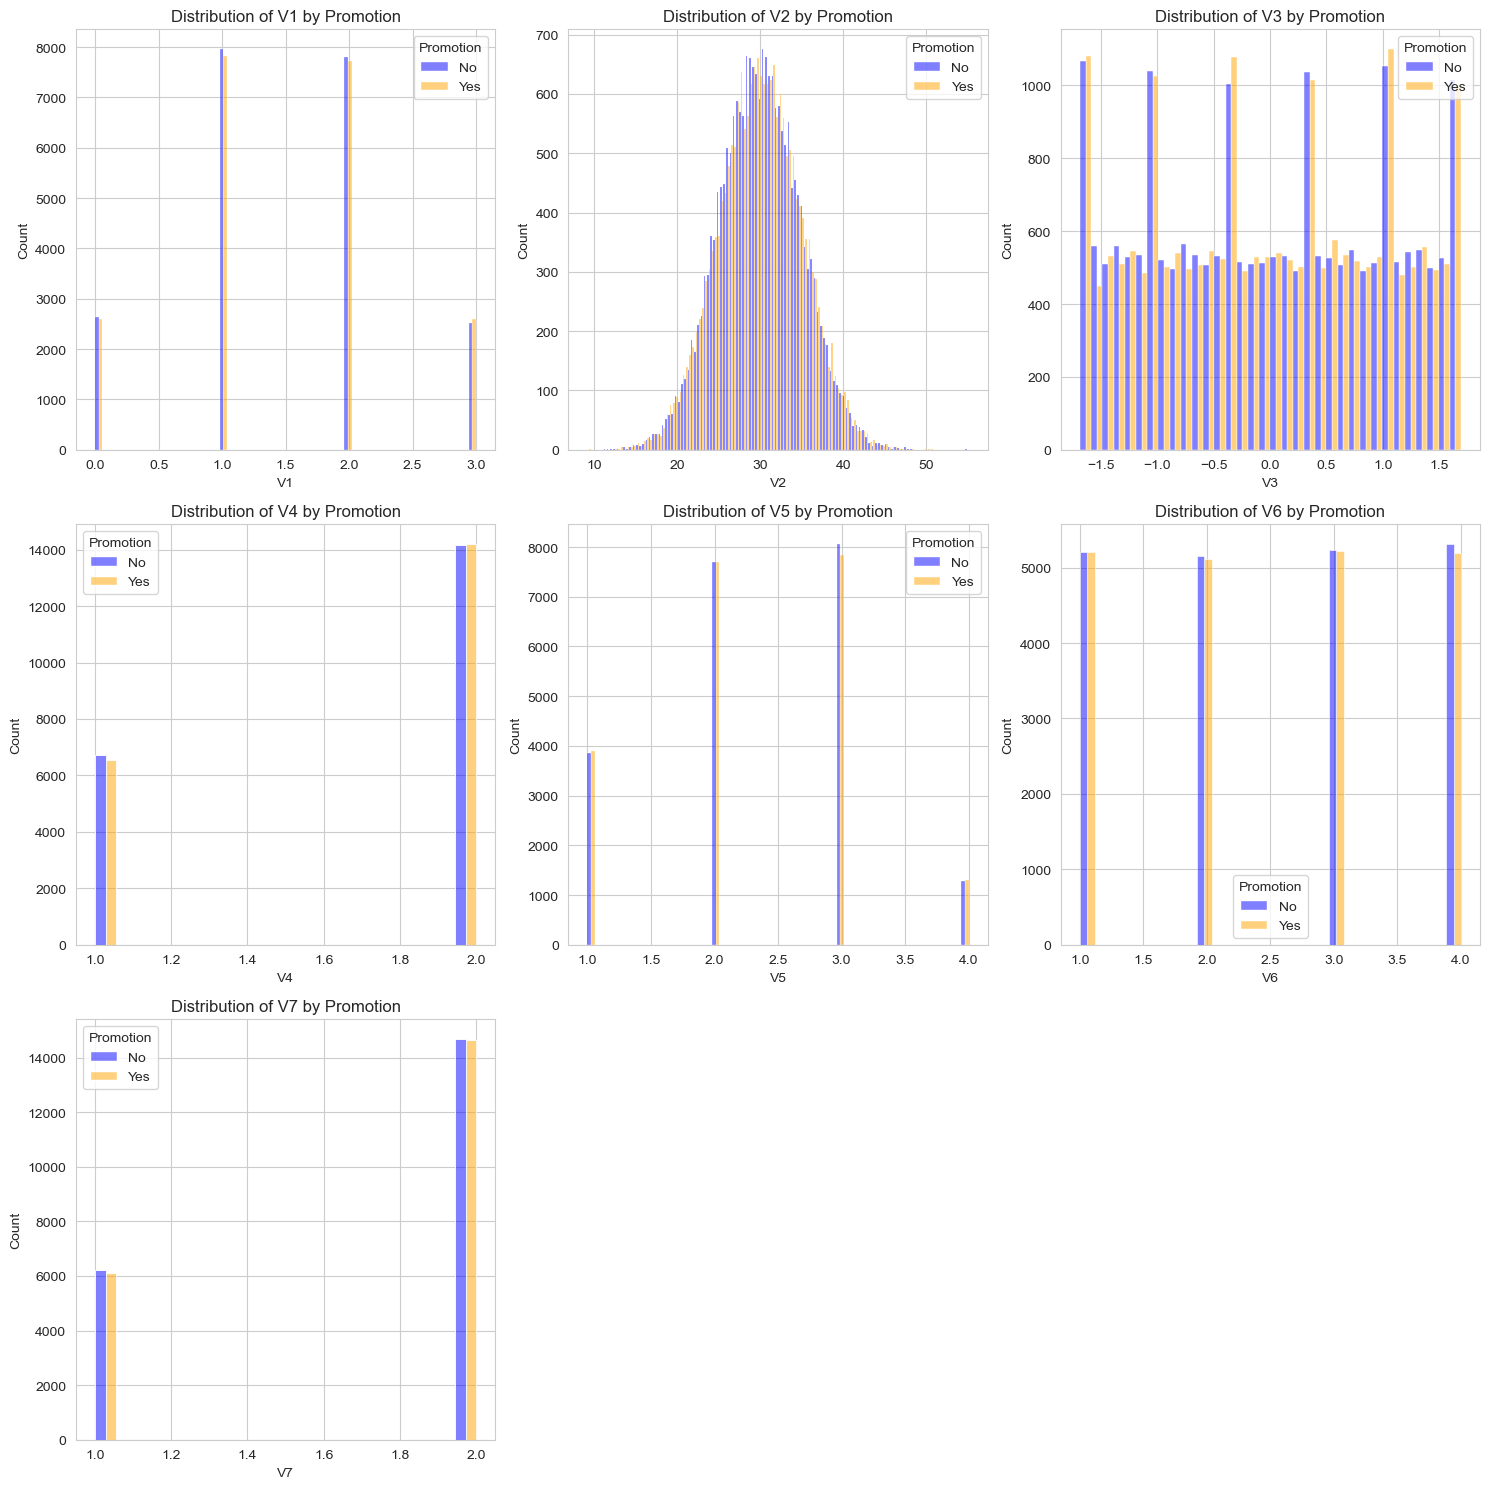

In [145]:
# Define the number of columns for the subplot grid
cols = 3
rows = (len(features) + cols - 1) // cols  # Calculate the number of rows required

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each feature in the 'features' list
for i, feature in enumerate(features):
    sns.histplot(data=test_data, x=feature, hue='Promotion', multiple='dodge', kde=False, alpha=0.5, palette=["blue", "orange"], ax=axes[i])
    axes[i].set_title(f"Distribution of {feature} by Promotion")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [146]:
# testing baseline model, where we send promotions to everyone

def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [147]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(np.float64(0.009593158278250108), np.float64(-1132.1999999999998))

# Model 1: Traditional

In [148]:
# read data
train_data = pd.read_csv('./Training.csv')
test_data = pd.read_csv('./Test.csv')

In [149]:
train_ctrl = train_data[train_data['Promotion']=='No']
train_treat = train_data[train_data['Promotion']=='Yes']

In [150]:
train_treat['purchase'].value_counts()

purchase
0    41643
1      721
Name: count, dtype: int64

In [151]:
train_treat

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2
8,15,Yes,0,2,31.930423,0.393317,2,3,1,2
10,17,Yes,0,1,32.770916,-1.511395,2,1,4,1
12,20,Yes,0,1,36.957009,0.133583,2,3,1,1
14,22,Yes,0,3,36.911714,-0.905350,2,2,4,1
...,...,...,...,...,...,...,...,...,...,...
84523,126170,Yes,0,1,29.978742,-0.126150,2,2,1,2
84525,126172,Yes,0,0,32.960205,-0.385883,2,3,3,2
84526,126173,Yes,0,3,34.132921,-0.472461,1,3,2,1
84527,126175,Yes,0,1,23.638557,1.605406,2,3,3,2


## Model 1: Traditional Response Modeling

In [152]:
# Features and target variable
X = train_treat[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y = train_treat['purchase']
X_test = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_test = test_data['purchase']

In [153]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
# Calculate scale_pos_weight due to the imbalanced classes
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

In [155]:
# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [156]:
# Set the evaluation set for monitoring the model's performance during training
evals = [(dtrain, 'train'), (dval, 'eval')]

In [157]:
# Define XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 3,
    "learning_rate": 0.1,
    "n_estimators": 100,
    "scale_pos_weight": scale_pos_weight,
    "random_state": 42
}

In [158]:
# Train the model using the specified parameters
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,  # Number of boosting rounds (iterations)
    evals=evals         # Evaluation set for early stopping or monitoring
)

[0]	train-logloss:0.68542	eval-logloss:0.68532
[1]	train-logloss:0.67908	eval-logloss:0.67901
[2]	train-logloss:0.67394	eval-logloss:0.67376
[3]	train-logloss:0.66941	eval-logloss:0.66929
[4]	train-logloss:0.66603	eval-logloss:0.66583
[5]	train-logloss:0.66300	eval-logloss:0.66284
[6]	train-logloss:0.66059	eval-logloss:0.66051
[7]	train-logloss:0.65865	eval-logloss:0.65845
[8]	train-logloss:0.65677	eval-logloss:0.65669
[9]	train-logloss:0.65525	eval-logloss:0.65522
[10]	train-logloss:0.65407	eval-logloss:0.65397
[11]	train-logloss:0.65290	eval-logloss:0.65286
[12]	train-logloss:0.65183	eval-logloss:0.65183
[13]	train-logloss:0.65102	eval-logloss:0.65089
[14]	train-logloss:0.65019	eval-logloss:0.65026
[15]	train-logloss:0.64945	eval-logloss:0.64960
[16]	train-logloss:0.64876	eval-logloss:0.64902
[17]	train-logloss:0.64781	eval-logloss:0.64833
[18]	train-logloss:0.64699	eval-logloss:0.64750
[19]	train-logloss:0.64475	eval-logloss:0.64535
[20]	train-logloss:0.64370	eval-logloss:0.64439
[2

/Users/linhchu/anaconda3/envs/new/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:20:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[54]	train-logloss:0.61943	eval-logloss:0.62203
[55]	train-logloss:0.61910	eval-logloss:0.62168
[56]	train-logloss:0.61856	eval-logloss:0.62125
[57]	train-logloss:0.61781	eval-logloss:0.62057
[58]	train-logloss:0.61733	eval-logloss:0.62013
[59]	train-logloss:0.61662	eval-logloss:0.61959
[60]	train-logloss:0.61626	eval-logloss:0.61919
[61]	train-logloss:0.61574	eval-logloss:0.61876
[62]	train-logloss:0.61523	eval-logloss:0.61823
[63]	train-logloss:0.61471	eval-logloss:0.61774
[64]	train-logloss:0.61397	eval-logloss:0.61708
[65]	train-logloss:0.61356	eval-logloss:0.61677
[66]	train-logloss:0.61324	eval-logloss:0.61655
[67]	train-logloss:0.61278	eval-logloss:0.61623
[68]	train-logloss:0.61250	eval-logloss:0.61602
[69]	train-logloss:0.61192	eval-logloss:0.61555
[70]	train-logloss:0.61137	eval-logloss:0.61502
[71]	train-logloss:0.61051	eval-logloss:0.61403
[72]	train-logloss:0.60989	eval-logloss:0.61343
[73]	train-logloss:0.60918	eval-logloss:0.61275
[74]	train-logloss:0.60867	eval-logloss:

In [159]:
test_data['response'] = model.predict(dtest)

In [160]:
y_pred_prob

array([0.08839279, 0.36333522, 0.43017748, ..., 0.2399429 , 0.3714606 ,
       0.23757753], dtype=float32)

/Users/linhchu/Documents/03. Data Analytics & Data Science/0. Projects/Starbucks Targeting Strategy/test_results.py:9: RuntimeWarning: invalid value encountered in scalar divide
  irr = n_treat_purch / n_treat - n_ctrl_purch / n_control


Threshold with max IRR: 0.74705
    → Max IRR: 0.1081 | Corresponding NIR: 34.4500
Threshold with max NIR: 0.51201
    → Max NIR: 328.8500 | Corresponding IRR: 0.0195


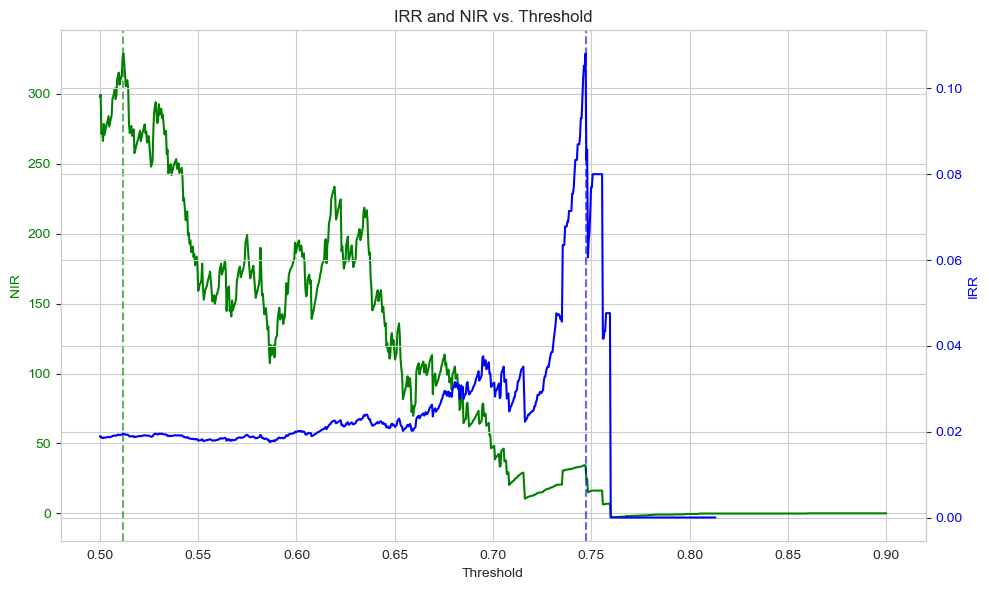

In [162]:
thresholds = np.linspace(0.5, 0.9, 1000)
nir_values = []
irr_values = []

for threshold in thresholds:
    test_data['promos'] = test_data['response'].apply(lambda x: 'Yes' if x > threshold else 'No')
    score_df = test_data.loc[test_data['promos'] == 'Yes']
    irr, nir = score(score_df)
    irr_values.append(irr)
    nir_values.append(nir)

# Find max NIR and corresponding IRR
max_nir_index = np.nanargmax(nir_values)
best_nir_threshold = thresholds[max_nir_index]
max_nir = nir_values[max_nir_index]
irr_at_max_nir = irr_values[max_nir_index]

# Find max IRR and corresponding NIR (ignoring NaNs safely)
irr_array = np.array(irr_values)
nir_array = np.array(nir_values)
threshold_array = np.array(thresholds)

valid_irr_mask = ~np.isnan(irr_array)
if valid_irr_mask.any():
    max_irr_index = np.argmax(irr_array[valid_irr_mask])
    true_indices = np.where(valid_irr_mask)[0]
    best_irr_index = true_indices[max_irr_index]

    best_irr_threshold = threshold_array[best_irr_index]
    max_irr = irr_array[best_irr_index]
    nir_at_max_irr = nir_array[best_irr_index]
else:
    best_irr_threshold = None
    max_irr = None
    nir_at_max_irr = None

# Print results
print(f"Threshold with max IRR: {best_irr_threshold:.5f}")
print(f"    → Max IRR: {max_irr:.4f} | Corresponding NIR: {nir_at_max_irr:.4f}")
print(f"Threshold with max NIR: {best_nir_threshold:.5f}")
print(f"    → Max NIR: {max_nir:.4f} | Corresponding IRR: {irr_at_max_nir:.4f}")

# Plot with secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot NIR on left y-axis
ax1.plot(thresholds, nir_values, color='green', label='NIR (Net Incremental Revenue)')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('NIR', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.axvline(best_nir_threshold, color='green', linestyle='--', alpha=0.6)

# Plot IRR on right y-axis
ax2 = ax1.twinx()
ax2.plot(thresholds, irr_values, color='blue', label='IRR (Incremental Response Rate)')
ax2.set_ylabel('IRR', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.axvline(best_irr_threshold, color='blue', linestyle='--', alpha=0.6)

# Titles and legends
plt.title('IRR and NIR vs. Threshold')
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# y_pred = (y_pred_prob > 0.51201.5).astype(int)
# promotion = np.where(y_pred == 1, "Yes", "No")

In [ ]:
# model_1 = test_data.assign(rec_promotion=promotion)
# model_1

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,rec_promotion
0,2,No,0,1,41.376390,1.172517,1,1,2,2,No
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2,No
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2,No
3,10,No,0,2,28.529691,-1.078506,2,3,2,2,Yes
4,12,No,0,2,32.378538,0.479895,2,2,1,2,No
...,...,...,...,...,...,...,...,...,...,...,...
41645,126166,No,0,1,33.073275,-0.126150,2,2,2,2,No
41646,126174,Yes,0,0,32.065720,0.999361,2,3,2,1,Yes
41647,126176,Yes,1,3,27.691221,1.172517,2,2,1,2,No
41648,126177,Yes,0,2,32.306427,0.566472,1,2,4,1,No


In [105]:
def promotion_strategy_1(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    dtest = xgb.DMatrix(df)
    
    y_pred_prob = model.predict(dtest)

    y_pred = (y_pred_prob > 0.51201).astype(int)
    promotion = np.where(y_pred == 1, "Yes", "No")

    return promotion

In [107]:
test_results(promotion_strategy_1)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0195.

Your nir with this strategy is 328.85.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(np.float64(0.01954518001146377), np.float64(328.85000000000014))

## Model 2: Uplift Modeling with Metalearner (S-learner)

The threshold with the maximum NIR is 0.01171 with a NIR of 453.2000


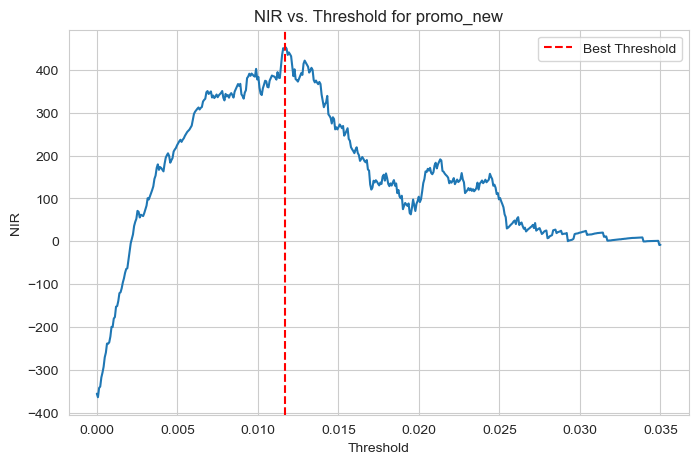

In [403]:
# Features and target variable
X_train = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_train = train_data['purchase']
X_test = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_test = test_data['purchase']

treat_train = train_data['Promotion'].map({'Yes': 1, 'No': 0})
treat_test = test_data['Promotion'].map({'Yes': 1, 'No': 0})

# Initialize and fit the T-Learner with XGBoost
s_learner = BaseSLearner(
                learner=xgb.XGBRegressor(
                    max_depth=5,
                    learning_rate=0.1,
                    n_estimators=100,
                    random_state=1
                    )
                )
s_learner.fit(X=X_train, treatment=treat_train, y=y_train)

# Predict uplift
test_data['s_learner'] = s_learner.predict(X=X_test)

thresholds = np.linspace(0, 0.035, 500)  # Generate 50 threshold values between 0 and 0.1
nir_values = []

for threshold in thresholds:
    test_data['promos_s'] = test_data['s_learner'].apply(lambda x: 'Yes' if x > threshold else 'No')
    score_df = test_data.loc[test_data['promos_s'] == 'Yes']
    _, nir = score(score_df)
    nir_values.append(nir)

# Find the threshold with the maximum NIR value
max_nir_index = np.argmax(nir_values)  # Index of the maximum NIR
best_threshold = thresholds[max_nir_index]  # Corresponding threshold for maximum NIR
max_nir = nir_values[max_nir_index]  # The maximum NIR value

# Output the best threshold and the maximum NIR
print(f"The threshold with the maximum NIR is {best_threshold:.5f} with a NIR of {max_nir:.4f}")

# Plotting the NIR values against different thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, nir_values)
plt.axvline(best_threshold, color='red', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('NIR')
plt.legend()
plt.title('NIR vs. Threshold for promo_new')
plt.grid(True)
plt.show()

In [409]:
def promotion_strategy_s(df):
    """
    Determines whether each user should receive the promotion based on predicted uplift.

    Args:
    df (pd.DataFrame): A dataframe containing the feature columns (V1 to V7).

    Returns:
    np.array: An array of 'Yes' (send promotion) or 'No' (do not send promotion).
    """
    # Predict uplift scores using the trained T-Learner model
    uplift_scores = s_learner.predict(X=df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']])

    # Assign promotion based on uplift (send promo if uplift > 0)
    promo = np.where(uplift_scores > 0.01171, 'Yes', 'No')

    # Ensure the output is a NumPy array to work with `np.where()` in test_results
    return promo.ravel()

In [410]:
test_results(promotion_strategy_s)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0204.

Your nir with this strategy is 452.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(np.float64(0.020418633899040566), np.float64(452.9000000000001))

## Model 3: Uplift Modeling with Metalearner (T-learner)

In [180]:
# Features and target variable
X_train = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_train = train_data['purchase']
X_test = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_test = test_data['purchase']

In [181]:
treat_train = train_data['Promotion'].map({'Yes': 1, 'No': 0})
treat_test = test_data['Promotion'].map({'Yes': 1, 'No': 0})

In [165]:
# Calculate scale_pos_weight due to the imbalanced classes
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

In [166]:
# Initialize and fit the T-Learner with XGBoost
t_learner = BaseTLearner(
                learner=xgb.XGBRegressor(
                    max_depth=3,
                    learning_rate=0.1,
                    n_estimators=100,
                    random_state=42
                    )
                )
t_learner.fit(X=X_train, treatment=treat_train, y=y_train)

In [167]:
# Predict uplift
test_data['t_learner'] = t_learner.predict(X=X_test)

The threshold with the maximum NIR is 0.01301 with a NIR of 377.7500


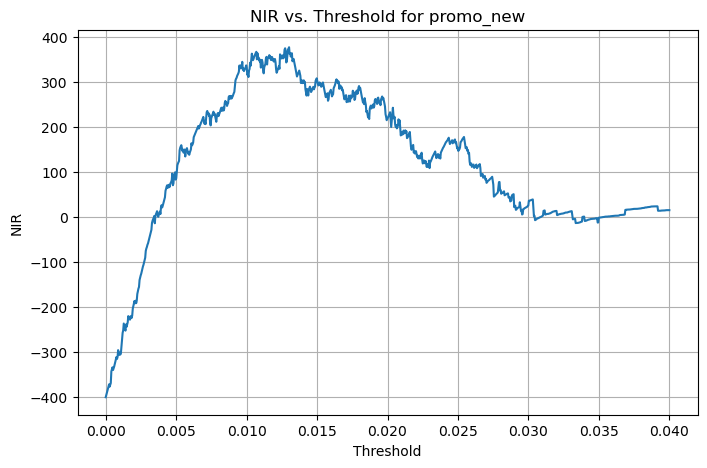

In [41]:
# #Old code
# thresholds = np.linspace(0, 0.04, 1000)  # Generate 50 threshold values between 0 and 0.1
# nir_values = []

# for threshold in thresholds:
#     test_data['promos'] = test_data['uplift'].apply(lambda x: 'Yes' if x > threshold else 'No')
#     score_df = test_data.loc[test_data['promos'] == 'Yes']
#     _, nir = score(score_df)
#     nir_values.append(nir)

# # Find the threshold with the maximum NIR value
# max_nir_index = np.argmax(nir_values)  # Index of the maximum NIR
# best_threshold = thresholds[max_nir_index]  # Corresponding threshold for maximum NIR
# max_nir = nir_values[max_nir_index]  # The maximum NIR value

# # Output the best threshold and the maximum NIR
# print(f"The threshold with the maximum NIR is {best_threshold:.5f} with a NIR of {max_nir:.4f}")

# # Plotting the NIR values against different thresholds
# plt.figure(figsize=(8, 5))
# plt.plot(thresholds, nir_values)
# plt.xlabel('Threshold')
# plt.ylabel('NIR')
# plt.title('NIR vs. Threshold for promo_new')
# plt.grid(True)
# plt.show()

Threshold with max IRR: 0.03900
    → Max IRR: 0.0370 | Corresponding NIR: 23.8000
Threshold with max NIR: 0.01301
    → Max NIR: 377.7500 | Corresponding IRR: 0.0198


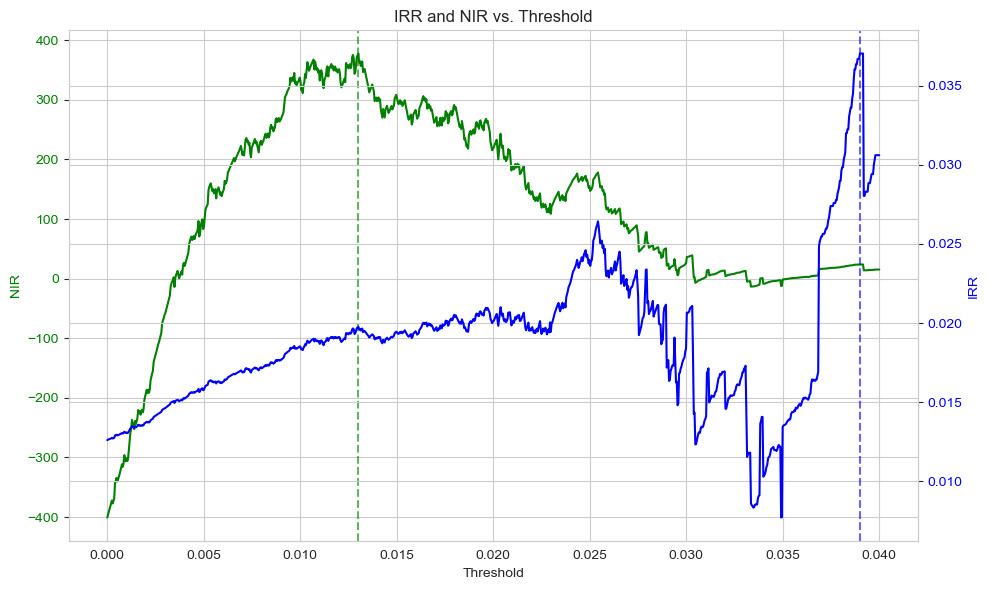

In [168]:
thresholds = np.linspace(0, 0.04, 1000)  # Generate 50 threshold values between 0 and 0.1
nir_values = []
irr_values = []

for threshold in thresholds:
    test_data['promos'] = test_data['t_learner'].apply(lambda x: 'Yes' if x > threshold else 'No')
    score_df = test_data.loc[test_data['promos'] == 'Yes']
    irr, nir = score(score_df)
    irr_values.append(irr)
    nir_values.append(nir)

# Find max NIR and corresponding IRR
max_nir_index = np.nanargmax(nir_values)
best_nir_threshold = thresholds[max_nir_index]
max_nir = nir_values[max_nir_index]
irr_at_max_nir = irr_values[max_nir_index]

# Find max IRR and corresponding NIR (ignoring NaNs safely)
irr_array = np.array(irr_values)
nir_array = np.array(nir_values)
threshold_array = np.array(thresholds)

valid_irr_mask = ~np.isnan(irr_array)
if valid_irr_mask.any():
    max_irr_index = np.argmax(irr_array[valid_irr_mask])
    true_indices = np.where(valid_irr_mask)[0]
    best_irr_index = true_indices[max_irr_index]

    best_irr_threshold = threshold_array[best_irr_index]
    max_irr = irr_array[best_irr_index]
    nir_at_max_irr = nir_array[best_irr_index]
else:
    best_irr_threshold = None
    max_irr = None
    nir_at_max_irr = None

# Print results
print(f"Threshold with max IRR: {best_irr_threshold:.5f}")
print(f"    → Max IRR: {max_irr:.4f} | Corresponding NIR: {nir_at_max_irr:.4f}")
print(f"Threshold with max NIR: {best_nir_threshold:.5f}")
print(f"    → Max NIR: {max_nir:.4f} | Corresponding IRR: {irr_at_max_nir:.4f}")

# Plot with secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot NIR on left y-axis
ax1.plot(thresholds, nir_values, color='green', label='NIR (Net Incremental Revenue)')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('NIR', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.axvline(best_nir_threshold, color='green', linestyle='--', alpha=0.6)

# Plot IRR on right y-axis
ax2 = ax1.twinx()
ax2.plot(thresholds, irr_values, color='blue', label='IRR (Incremental Response Rate)')
ax2.set_ylabel('IRR', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.axvline(best_irr_threshold, color='blue', linestyle='--', alpha=0.6)

# Titles and legends
plt.title('IRR and NIR vs. Threshold')
fig.tight_layout()
plt.grid(True)
plt.show()

In [169]:
def promotion_strategy_2(df):
    """
    Determines whether each user should receive the promotion based on predicted uplift.

    Args:
    df (pd.DataFrame): A dataframe containing the feature columns (V1 to V7).

    Returns:
    np.array: An array of 'Yes' (send promotion) or 'No' (do not send promotion).
    """
    # Predict uplift scores using the trained T-Learner model
    uplift_scores = t_learner.predict(X=df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']])

    # Assign promotion based on uplift (send promo if uplift > 0)
    promo = np.where(uplift_scores > 0.013, 'Yes', 'No')

    # Ensure the output is a NumPy array to work with `np.where()` in test_results
    return promo.ravel()

In [171]:
test_results(promotion_strategy_2)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0198.

Your nir with this strategy is 377.30.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(np.float64(0.019751054062501484), np.float64(377.29999999999995))

## Model 4: Uplift Modeling with Metalearner (X-learner)

In [87]:
# Initialize and fit the X-Learner with XGBoost
x_learner = BaseXLearner(
                learner=xgb.XGBRegressor(
                    max_depth=3,
                    learning_rate=0.1,
                    n_estimators=100,
                    random_state=42
                    )
                )
x_learner.fit(X=X_train, treatment=treat_train, y=y_train)

In [55]:
def promotion_strategy(df):
    """
    Determines whether each user should receive the promotion based on predicted uplift.

    Args:
    df (pd.DataFrame): A dataframe containing the feature columns (V1 to V7).

    Returns:
    np.array: An array of 'Yes' (send promotion) or 'No' (do not send promotion).
    """
    # Predict uplift scores using the trained T-Learner model
    uplift_scores = x_learner.predict(X=df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']])

    # Assign promotion based on uplift (send promo if uplift > 0)
    promo = np.where(uplift_scores > 0.01122, 'Yes', 'No')

    # Ensure the output is a NumPy array to work with `np.where()` in test_results
    return promo.ravel()

In [56]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0204.

Your nir with this strategy is 465.10.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(np.float64(0.020435985662654303), np.float64(465.10000000000014))

In [88]:
# Predict uplift
test_data['uplift_x'] = x_learner.predict(X=X_test)

The threshold with the maximum NIR is 0.01122 with a NIR of 465.2500


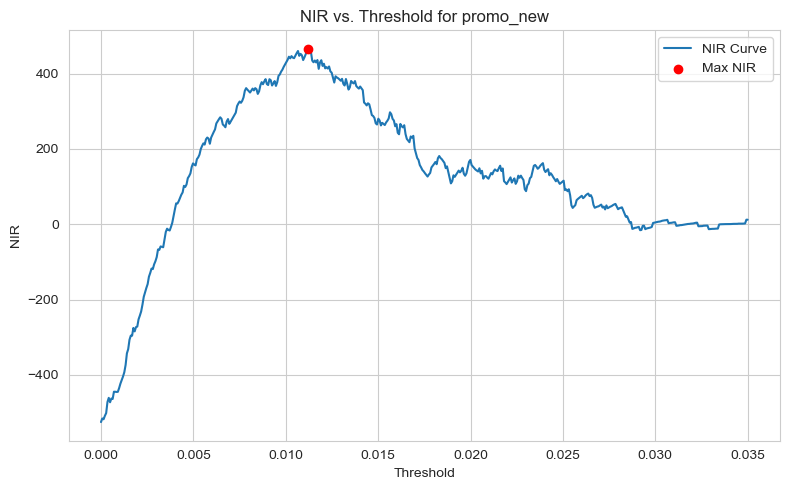

In [89]:
thresholds = np.linspace(0, 0.035, 500)  # Generate 50 threshold values between 0 and 0.1
nir_values = []

for threshold in thresholds:
    test_data['promos_x'] = test_data['uplift_x'].apply(lambda x: 'Yes' if x > threshold else 'No')
    score_df = test_data.loc[test_data['promos_x'] == 'Yes']
    _, nir = score(score_df)
    nir_values.append(nir)

# Find the threshold with the maximum NIR value
max_nir_index = np.argmax(nir_values)  # Index of the maximum NIR
best_threshold = thresholds[max_nir_index]  # Corresponding threshold for maximum NIR
max_nir = nir_values[max_nir_index]  # The maximum NIR value

# Output the best threshold and the maximum NIR
print(f"The threshold with the maximum NIR is {best_threshold:.5f} with a NIR of {max_nir:.4f}")

# Plot with red dot at max NIR
plt.figure(figsize=(8, 5))
plt.plot(thresholds, nir_values, label='NIR Curve')
plt.scatter([best_threshold], [max_nir], color='red', label='Max NIR', zorder=5)
plt.xlabel('Threshold')
plt.ylabel('NIR')
plt.title('NIR vs. Threshold for promo_new')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
promotion = np.where(test_data['uplift_x'] > 0.01122, 'Yes', 'No')
model_3 = test_data.assign(rec_promotion=promotion)
model_3

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,uplift,promos,uplift_x,promos_x,rec_promotion
0,2,No,0,1,41.376390,1.172517,1,1,2,2,-0.012096,No,-0.006990,No,No
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2,-0.002053,No,0.002770,No,No
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2,0.021042,No,0.022661,No,Yes
3,10,No,0,2,28.529691,-1.078506,2,3,2,2,0.022207,No,0.023565,No,Yes
4,12,No,0,2,32.378538,0.479895,2,2,1,2,0.003901,No,0.004150,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41645,126166,No,0,1,33.073275,-0.126150,2,2,2,2,0.005838,No,0.007443,No,No
41646,126174,Yes,0,0,32.065720,0.999361,2,3,2,1,0.016544,No,0.014597,No,Yes
41647,126176,Yes,1,3,27.691221,1.172517,2,2,1,2,-0.004932,No,-0.003099,No,No
41648,126177,Yes,0,2,32.306427,0.566472,1,2,4,1,-0.001839,No,-0.000160,No,No


In [123]:
model_3['rec_promotion'].value_counts()

rec_promotion
No     23945
Yes    17705
Name: count, dtype: int64

## Model 5: Uplift Modeling with Metalearner (X-learner with hyperparameter tuning)

In [232]:
# Features and target variable
X_train = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_train = train_data['purchase']
X_test = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_test = test_data['purchase']
treat_train = train_data['Promotion'].map({'Yes': 1, 'No': 0})
treat_test = test_data['Promotion'].map({'Yes': 1, 'No': 0})

In [221]:
# Features and target variable
# X_treat = train_treat[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
# y_treat = train_treat['purchase']
# X_ctrl = train_ctrl[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
# y_ctrl = train_ctrl['purchase']
# Rename

X1_train = train_treat[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y1_train = train_treat['purchase']
X0_train = train_ctrl[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y0_train = train_ctrl['purchase']

# Split data into training and validation sets -> use cv instead of train val split
# X_train_treat, X_val_treat, y_train_treat, y_val_treat = train_test_split(X_treat, y_treat, test_size=0.2, random_state=42)
# X_train_ctrl, X_val_ctrl, y_train_ctrl, y_val_ctrl = train_test_split(X_ctrl, y_ctrl, test_size=0.2, random_state=42)

In [191]:
# # Calculate scale_pos_weight due to the imbalanced classes
# scale_pos_weight_treat = sum(y_treat == 0) / sum(y_treat == 1)
# scale_pos_weight_ctrl = sum(y_ctrl == 0) / sum(y_ctrl == 1)

In [ ]:
# def objective(trial, X_train, y_train, X_val, y_val):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
#         "random_state": 42
#     }
    
#     model = xgb.XGBClassifier(**params, eval_metric="logloss")
#     model.fit(X_train, y_train)
    
#     y_pred_prob = model.predict_proba(X_val)[:, 1]
#     return log_loss(y_val, y_pred_prob)  # Optimize log loss

In [ ]:
# # Optimize for treatment group
# study_treat = optuna.create_study(direction="minimize")
# study_treat.optimize(lambda trial: objective(trial, X_train_treat, y_train_treat, X_val_treat, y_val_treat), n_trials=100)
# best_params_treat = study_treat.best_params  # Best params for treatment model

# # Optimize for control group
# study_ctrl = optuna.create_study(direction="minimize")
# study_ctrl.optimize(lambda trial: objective(trial, X_train_ctrl, y_train_ctrl, X_val_ctrl, y_val_ctrl), n_trials=100)
# best_params_ctrl = study_ctrl.best_params  # Best params for control model

[I 2025-04-08 01:31:03,317] A new study created in memory with name: no-name-73bfdc60-3910-405a-8deb-f884c7e23a58
[I 2025-04-08 01:31:03,975] Trial 0 finished with value: 0.09171709787589513 and parameters: {'n_estimators': 364, 'max_depth': 10, 'learning_rate': 0.02366596928193278, 'subsample': 0.7117811187936176, 'colsample_bytree': 0.5794551670066197, 'reg_alpha': 1.210935285880582, 'reg_lambda': 4.661159371025967}. Best is trial 0 with value: 0.09171709787589513.
[I 2025-04-08 01:31:04,408] Trial 1 finished with value: 0.0959808094560329 and parameters: {'n_estimators': 412, 'max_depth': 5, 'learning_rate': 0.047074519364882446, 'subsample': 0.9575990339787891, 'colsample_bytree': 0.8512206611631971, 'reg_alpha': 3.179681590245312e-05, 'reg_lambda': 0.0005642648417923975}. Best is trial 0 with value: 0.09171709787589513.
[I 2025-04-08 01:31:04,568] Trial 2 finished with value: 0.08998047493553539 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.0349273689092

In [194]:
# Train the optimized treatment model
model_treat = xgb.XGBClassifier(**best_params_treat, eval_metric="logloss")
# model_treat.fit(X_train_treat, y_train_treat)

# Train the optimized control model
model_ctrl = xgb.XGBClassifier(**best_params_ctrl, eval_metric="logloss")
# model_ctrl.fit(X_train_ctrl, y_train_ctrl)

# # Evaluate Log Loss
# y_pred_treat = model_treat.predict_proba(X_test_treat)[:, 1]
# y_pred_ctrl = model_ctrl.predict_proba(X_test_ctrl)[:, 1]

# log_loss_treat = log_loss(y_test_treat, y_pred_treat)
# log_loss_ctrl = log_loss(y_test_ctrl, y_pred_ctrl)

# print(f"Log Loss (Treatment Model): {log_loss_treat:.4f}")
# print(f"Log Loss (Control Model): {log_loss_ctrl:.4f}")

In [195]:
# Define models for outcome and effect estimation
# outcome_learner = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
effect_learner = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

# Initialize BaseXClassifier
x_learner = BaseXClassifier(
    control_outcome_learner=model_ctrl,
    treatment_outcome_learner=model_treat,
    effect_learner=effect_learner
)

# Train the model
x_learner.fit(X_train, treat_train, y_train)

In [289]:
(len(y0_train) - sum(y0_train)) / sum(y0_train)

131.19435736677116

In [293]:
(len(y1_train) - sum(y1_train)) / sum(y1_train)

57.75728155339806

In [291]:
y0_train.value_counts()

purchase
0    41851
1      319
Name: count, dtype: int64

In [292]:
y1_train.value_counts()

purchase
0    41643
1      721
Name: count, dtype: int64

In [374]:
# New Optuna code that use cv and maximize neg_log_loss
def tune_outcome_model(X, y, n_trials=50):
    # Calculate actual class ratio for guidance
    # class_ratio = (len(y) - sum(y)) / sum(y)

    def objective(trial):
    
        model = xgb.XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 7),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            # scale_pos_weight = trial.suggest_float("scale_pos_weight", 1.0, 3.0),
            random_state=17,
            eval_metric='logloss'
        )

        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
        score = cross_val_score(model, X, y, cv=cv, scoring='neg_log_loss')
        return score.mean()  # higher is better because it's negative log loss
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    best_model = xgb.XGBClassifier(
        **study.best_params, 
        random_state=17, 
        eval_metric='logloss'
    )
    best_model.fit(X, y)

    return best_model, study.best_params, study.best_value

In [295]:
# Fit outcome models
# M0 for control group
m0_model, m0_params, m0_score = tune_outcome_model(X0_train, y0_train)

# M1 for control group
m1_model, m1_params, m1_score = tune_outcome_model(X1_train, y1_train)

[I 2025-04-09 03:02:40,071] A new study created in memory with name: no-name-98e71027-c3ae-4446-bcd7-87d1bc86a424


[I 2025-04-09 03:02:41,232] Trial 0 finished with value: -0.04653896727503027 and parameters: {'n_estimators': 104, 'max_depth': 4, 'learning_rate': 0.21393220876808644, 'subsample': 0.861778843713313, 'colsample_bytree': 0.8521071037770763}. Best is trial 0 with value: -0.04653896727503027.
[I 2025-04-09 03:02:42,549] Trial 1 finished with value: -0.04462881404994186 and parameters: {'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.01661277417933721, 'subsample': 0.6547952417575682, 'colsample_bytree': 0.6805172680844392}. Best is trial 1 with value: -0.04462881404994186.
[I 2025-04-09 03:02:45,178] Trial 2 finished with value: -0.0526890257258408 and parameters: {'n_estimators': 163, 'max_depth': 7, 'learning_rate': 0.2040662861152057, 'subsample': 0.9546858250640231, 'colsample_bytree': 0.62405660627255}. Best is trial 1 with value: -0.04462881404994186.
[I 2025-04-09 03:02:47,866] Trial 3 finished with value: -0.048978645480396585 and parameters: {'n_estimators': 194, 'max_d

In [296]:
# Impute counterfactuals and compute tau hat
# Impute Y0 for treated
y0_hat_treated = m0_model.predict_proba(X1_train)[:, 1]
tau1_hat = y1_train - y0_hat_treated  # τ̂1

# Impute Y1 for control
y1_hat_control = m1_model.predict_proba(X0_train)[:, 1]
tau0_hat = y1_hat_control - y0_train  # τ̂0

In [375]:
# Optuna function to tune effect models
def tune_effect_model(X, tau_hat, n_trials=50):
    def objective(trial):
        model = xgb.XGBRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 7),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            random_state=17,
            n_jobs=-1
        )

        cv = KFold(n_splits=10, shuffle=True, random_state=17)
        score = cross_val_score(model, X, tau_hat, cv=cv, scoring='neg_mean_squared_error')
        return score.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    best_model = xgb.XGBRegressor(**study.best_params, random_state=17)
    best_model.fit(X, tau_hat)

    return best_model, study.best_params, study.best_value

In [298]:
# τ̂1 model (trained on treated group)
tau1_model, tau1_params, tau1_score = tune_effect_model(X1_train, tau1_hat)

# τ̂0 model (trained on control group)
tau0_model, tau0_params, tau0_score = tune_effect_model(X0_train, tau0_hat)

[I 2025-04-09 03:05:31,729] A new study created in memory with name: no-name-473c5692-6e39-46c4-ab73-0b864d0371bd
[I 2025-04-09 03:05:34,639] Trial 0 finished with value: -0.01670859261555147 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.02625299382545836, 'subsample': 0.6515672141965444, 'colsample_bytree': 0.8459408871917367}. Best is trial 0 with value: -0.01670859261555147.
[I 2025-04-09 03:05:37,842] Trial 1 finished with value: -0.017259871332040634 and parameters: {'n_estimators': 203, 'max_depth': 7, 'learning_rate': 0.07689150141999955, 'subsample': 0.6237001180076561, 'colsample_bytree': 0.8226431973272632}. Best is trial 0 with value: -0.01670859261555147.
[I 2025-04-09 03:05:40,649] Trial 2 finished with value: -0.017188023107345473 and parameters: {'n_estimators': 241, 'max_depth': 6, 'learning_rate': 0.11279495875870314, 'subsample': 0.9919103090887321, 'colsample_bytree': 0.8160935700844937}. Best is trial 0 with value: -0.01670859261555147.
[I

In [299]:
# Initialize BaseXClassifier
x_learner = BaseXClassifier(
    control_outcome_learner=m0_model,
    treatment_outcome_learner=m1_model,
    control_effect_learner=tau0_model,
    treatment_effect_learner=tau1_model
)

# Train the model
x_learner.fit(X_train, treat_train, y_train)

In [300]:
# Predict uplift
test_data['tuned_x_learner'] = x_learner.predict(X=X_test)

Threshold with max IRR: 0.02230
    → Max IRR: 0.0297 | Corresponding NIR: 112.8500
Threshold with max NIR: 0.01052
    → Max NIR: 510.8000 | Corresponding IRR: 0.0206


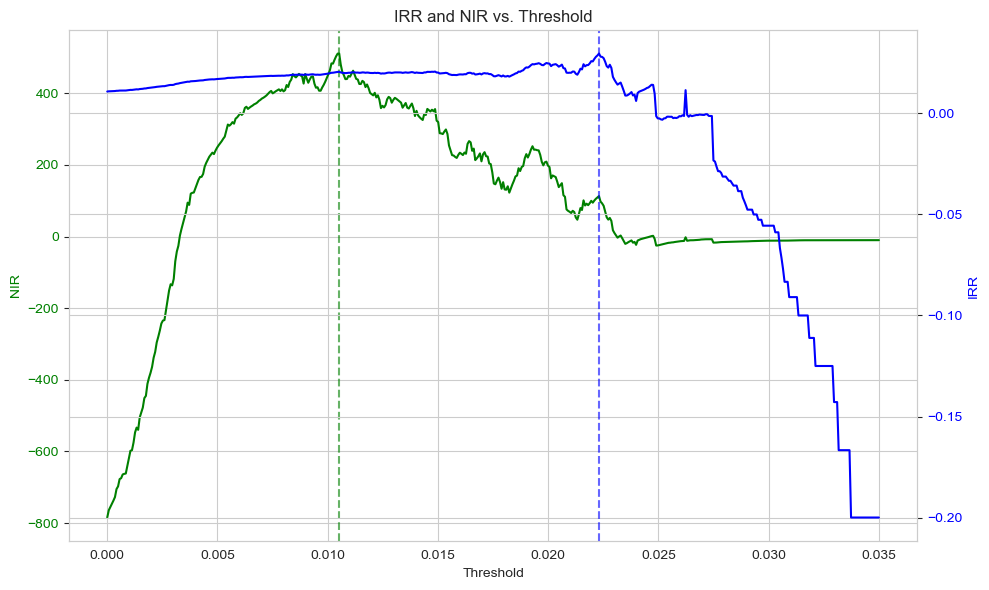

In [301]:
thresholds = np.linspace(0, 0.035, 500)  # Generate 50 threshold values between 0 and 0.1
nir_values = []
irr_values = []

for threshold in thresholds:
    test_data['promos'] = test_data['tuned_x_learner'].apply(lambda x: 'Yes' if x > threshold else 'No')
    score_df = test_data.loc[test_data['promos'] == 'Yes']
    irr, nir = score(score_df)
    irr_values.append(irr)
    nir_values.append(nir)

# Find max NIR and corresponding IRR
max_nir_index = np.nanargmax(nir_values)
best_nir_threshold = thresholds[max_nir_index]
max_nir = nir_values[max_nir_index]
irr_at_max_nir = irr_values[max_nir_index]

# Find max IRR and corresponding NIR (ignoring NaNs safely)
irr_array = np.array(irr_values)
nir_array = np.array(nir_values)
threshold_array = np.array(thresholds)

valid_irr_mask = ~np.isnan(irr_array)
if valid_irr_mask.any():
    max_irr_index = np.argmax(irr_array[valid_irr_mask])
    true_indices = np.where(valid_irr_mask)[0]
    best_irr_index = true_indices[max_irr_index]

    best_irr_threshold = threshold_array[best_irr_index]
    max_irr = irr_array[best_irr_index]
    nir_at_max_irr = nir_array[best_irr_index]
else:
    best_irr_threshold = None
    max_irr = None
    nir_at_max_irr = None

# Print results
print(f"Threshold with max IRR: {best_irr_threshold:.5f}")
print(f"    → Max IRR: {max_irr:.4f} | Corresponding NIR: {nir_at_max_irr:.4f}")
print(f"Threshold with max NIR: {best_nir_threshold:.5f}")
print(f"    → Max NIR: {max_nir:.4f} | Corresponding IRR: {irr_at_max_nir:.4f}")

# Plot with secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot NIR on left y-axis
ax1.plot(thresholds, nir_values, color='green', label='NIR (Net Incremental Revenue)')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('NIR', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.axvline(best_nir_threshold, color='green', linestyle='--', alpha=0.6)

# Plot IRR on right y-axis
ax2 = ax1.twinx()
ax2.plot(thresholds, irr_values, color='blue', label='IRR (Incremental Response Rate)')
ax2.set_ylabel('IRR', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.axvline(best_irr_threshold, color='blue', linestyle='--', alpha=0.6)

# Titles and legends
plt.title('IRR and NIR vs. Threshold')
fig.tight_layout()
plt.grid(True)
plt.show()

The threshold with the maximum NIR is 0.01052 with a NIR of 510.3500


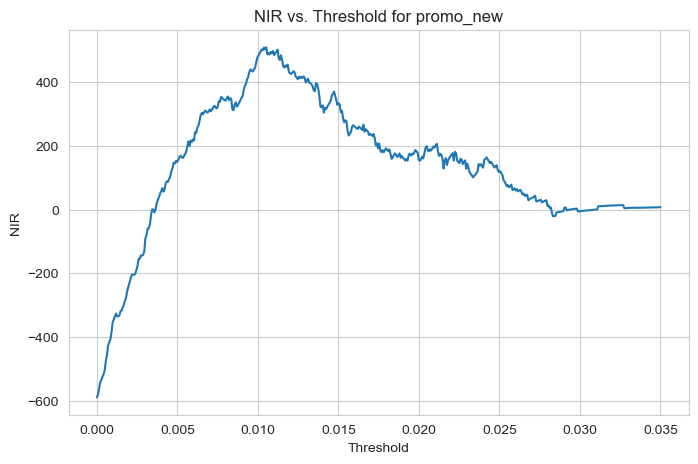

In [119]:
thresholds = np.linspace(0, 0.035, 500)  # Generate 50 threshold values between 0 and 0.1
nir_values = []

for threshold in thresholds:
    test_data['promos_x'] = test_data['uplift_x'].apply(lambda x: 'Yes' if x > threshold else 'No')
    score_df = test_data.loc[test_data['promos_x'] == 'Yes']
    _, nir = score(score_df)
    nir_values.append(nir)

# Find the threshold with the maximum NIR value
max_nir_index = np.argmax(nir_values)  # Index of the maximum NIR
best_threshold = thresholds[max_nir_index]  # Corresponding threshold for maximum NIR
max_nir = nir_values[max_nir_index]  # The maximum NIR value

# Output the best threshold and the maximum NIR
print(f"The threshold with the maximum NIR is {best_threshold:.5f} with a NIR of {max_nir:.4f}")

# Plotting the NIR values against different thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, nir_values)
plt.xlabel('Threshold')
plt.ylabel('NIR')
plt.title('NIR vs. Threshold for promo_new')
plt.grid(True)
plt.show()

In [ ]:
thresholds = np.linspace(0, 0.035, 500)  # Generate 50 threshold values between 0 and 0.1
nir_values = []

for threshold in thresholds:
    test_data['promos_x'] = test_data['uplift_x'].apply(lambda x: 'Yes' if x > threshold else 'No')
    score_df = test_data.loc[test_data['promos_x'] == 'Yes']
    _, nir = score(score_df)
    nir_values.append(nir)

# Find the threshold with the maximum NIR value
max_nir_index = np.argmax(nir_values)  # Index of the maximum NIR
best_threshold = thresholds[max_nir_index]  # Corresponding threshold for maximum NIR
max_nir = nir_values[max_nir_index]  # The maximum NIR value

# Output the best threshold and the maximum NIR
print(f"The threshold with the maximum NIR is {best_threshold:.5f} with a NIR of {max_nir:.4f}")

# Plotting the NIR values against different thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, nir_values)
plt.xlabel('Threshold')
plt.ylabel('NIR')
plt.title('NIR vs. Threshold for promo_new')
plt.grid(True)
plt.show()

In [371]:
def tune_outcome_model(X, y, n_trials=100):
    def objective(trial):
        model = xgb.XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 7),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            random_state=17,
            eval_metric='logloss'
        )
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
        return cross_val_score(model, X, y, cv=cv, scoring='neg_log_loss').mean()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    best_model = xgb.XGBClassifier(**study.best_params, random_state=17, eval_metric='logloss')
    best_model.fit(X, y)
    return best_model

def tune_effect_model(X, tau_hat, n_trials=100):
    def objective(trial):
        model = xgb.XGBRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 7),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            random_state=17,
            n_jobs=-1
        )
        cv = KFold(n_splits=10, shuffle=True, random_state=17)
        return cross_val_score(model, X, tau_hat, cv=cv, scoring='neg_mean_squared_error').mean()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    best_model = xgb.XGBRegressor(**study.best_params, random_state=17)
    best_model.fit(X, tau_hat)
    return best_model

def train_xlearner_pipeline(
    X_train, treat_train, y_train,
    X0_train, y0_train, X1_train, y1_train,
    tau0_hat, tau1_hat,
    X_test, test_data, score_fn,
    uplift_col='uplift_x', threshold_range=(0, 0.035), n_thresholds=500
):
    # Train outcome models
    m0_model = tune_outcome_model(X0_train, y0_train)
    m1_model = tune_outcome_model(X1_train, y1_train)

    # Train effect models
    tau0_model = tune_effect_model(X0_train, tau0_hat)
    tau1_model = tune_effect_model(X1_train, tau1_hat)

    # Initialize and fit X-learner
    x_learner = BaseXClassifier(
        control_outcome_learner=m0_model,
        treatment_outcome_learner=m1_model,
        control_effect_learner=tau0_model,
        treatment_effect_learner=tau1_model
    )
    x_learner.fit(X=X_train, treatment=treat_train, y=y_train)

    # Predict uplift
    test_data['tuned_x_learner'] = x_learner.predict(X=X_test)

    # Sweep thresholds and evaluate NIR
    thresholds = np.linspace(threshold_range[0], threshold_range[1], n_thresholds)
    nir_values = []
    for threshold in thresholds:
        test_data['promos_x'] = test_data[uplift_col].apply(lambda x: 'Yes' if x > threshold else 'No')
        score_df = test_data[test_data['promos_x'] == 'Yes']
        _, nir = score_fn(score_df)
        nir_values.append(nir)

    max_nir_index = np.argmax(nir_values)
    best_threshold = thresholds[max_nir_index]
    max_nir = nir_values[max_nir_index]

    print(f"The threshold with the maximum NIR is {best_threshold:.5f} with a NIR of {max_nir:.4f}")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, nir_values)
    plt.axvline(best_threshold, color='red', linestyle='--', label='Best Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('NIR')
    plt.title('NIR vs. Threshold for uplift predictions')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'x_learner': x_learner,
        'best_threshold': best_threshold,
        'max_nir': max_nir,
        'test_data': test_data,
    }

[I 2025-04-19 00:01:26,772] A new study created in memory with name: no-name-b4cf711e-c12f-4d67-b724-43a7c934a771
[I 2025-04-19 00:01:30,854] Trial 0 finished with value: -0.057944494745411725 and parameters: {'n_estimators': 268, 'max_depth': 6, 'learning_rate': 0.22180401356146115, 'subsample': 0.9242637556298114, 'colsample_bytree': 0.9343469616044762}. Best is trial 0 with value: -0.057944494745411725.
[I 2025-04-19 00:01:32,502] Trial 1 finished with value: -0.047896011790153556 and parameters: {'n_estimators': 213, 'max_depth': 4, 'learning_rate': 0.15003569564252361, 'subsample': 0.7782726388686021, 'colsample_bytree': 0.8073303124067767}. Best is trial 1 with value: -0.047896011790153556.
[I 2025-04-19 00:01:33,828] Trial 2 finished with value: -0.04927311852770739 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.29462130369217737, 'subsample': 0.7800263171201218, 'colsample_bytree': 0.8365963955084799}. Best is trial 1 with value: -0.047896011790153556.

The threshold with the maximum NIR is 0.01108 with a NIR of 477.5000


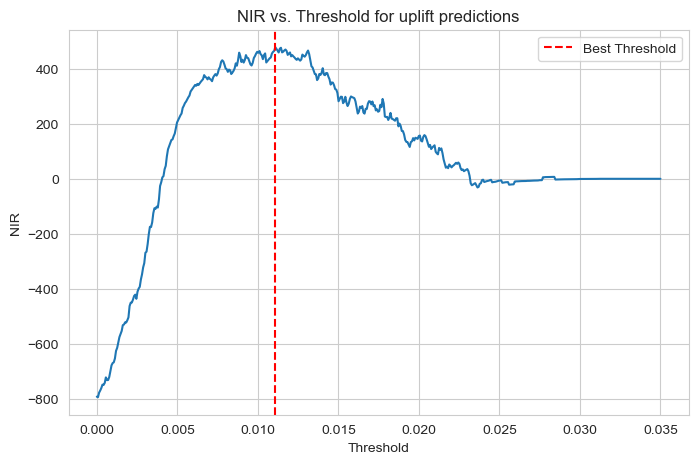

In [372]:
results = train_xlearner_pipeline(
    X_train=X_train,
    treat_train=treat_train,
    y_train=y_train,
    X0_train=X0_train,
    y0_train=y0_train,
    X1_train=X1_train,
    y1_train=y1_train,
    tau0_hat=tau0_hat,
    tau1_hat=tau1_hat,
    X_test=X_test,
    test_data=test_data,
    score_fn=score,  # your custom NIR scoring function
    uplift_col='tuned_x_learner',
)


[I 2025-04-19 23:08:38,106] A new study created in memory with name: no-name-1a69eca4-b4b8-4f40-87fd-0160919fbbf7
[I 2025-04-19 23:08:39,040] Trial 0 finished with value: -0.04686272954971758 and parameters: {'n_estimators': 106, 'max_depth': 3, 'learning_rate': 0.29173803642795154, 'subsample': 0.613276138673178, 'colsample_bytree': 0.6065583917621012}. Best is trial 0 with value: -0.04686272954971758.
[I 2025-04-19 23:08:40,750] Trial 1 finished with value: -0.048446735768490345 and parameters: {'n_estimators': 128, 'max_depth': 5, 'learning_rate': 0.19684741933445069, 'subsample': 0.7570545086747495, 'colsample_bytree': 0.657520184924364}. Best is trial 0 with value: -0.04686272954971758.
[I 2025-04-19 23:08:44,527] Trial 2 finished with value: -0.04838819430359235 and parameters: {'n_estimators': 274, 'max_depth': 4, 'learning_rate': 0.16831948683491996, 'subsample': 0.7461400869719926, 'colsample_bytree': 0.628087480060637}. Best is trial 0 with value: -0.04686272954971758.
[I 202

The threshold with the maximum NIR is 0.01010 with a NIR of 493.0500


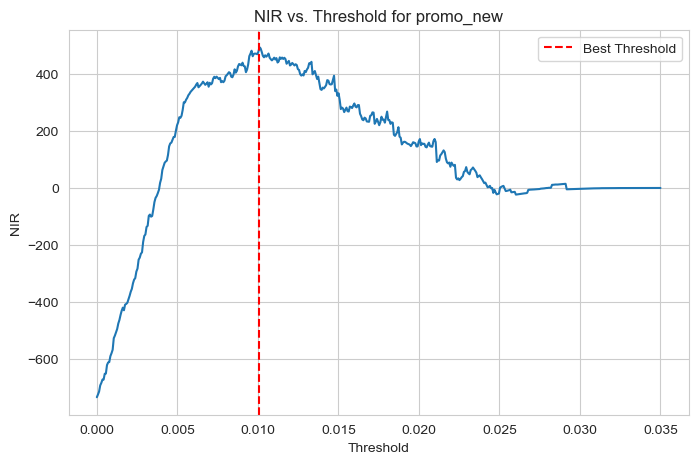

In [380]:
# Fit outcome models
m0_model, m0_params, m0_score = tune_outcome_model(X0_train, y0_train, n_trials=100)
m1_model, m1_params, m1_score = tune_outcome_model(X1_train, y1_train, n_trials=100)

# Impute counterfactuals and compute tau hat
y0_hat_treated = m0_model.predict_proba(X1_train)[:, 1]
tau1_hat = y1_train - y0_hat_treated 
y1_hat_control = m1_model.predict_proba(X0_train)[:, 1]
tau0_hat = y1_hat_control - y0_train

# Fit effect models
tau1_model, tau1_params, tau1_score = tune_effect_model(X1_train, tau1_hat, n_trials=100)
tau0_model, tau0_params, tau0_score = tune_effect_model(X0_train, tau0_hat, n_trials=100)

# Initialize BaseXClassifier
x_learner = BaseXClassifier(
    control_outcome_learner=m0_model,
    treatment_outcome_learner=m1_model,
    control_effect_learner=tau0_model,
    treatment_effect_learner=tau1_model
)

# Train the model
x_learner.fit(X_train, treat_train, y_train)

# Predict uplift
test_data['tuned_x_learner_100'] = x_learner.predict(X=X_test)

thresholds = np.linspace(0, 0.035, 500)  # Generate 50 threshold values between 0 and 0.1
nir_values = []

for threshold in thresholds:
    test_data['promos_x'] = test_data['tuned_x_learner_100'].apply(lambda x: 'Yes' if x > threshold else 'No')
    score_df = test_data.loc[test_data['promos_x'] == 'Yes']
    _, nir = score(score_df)
    nir_values.append(nir)

# Find the threshold with the maximum NIR value
max_nir_index = np.argmax(nir_values)  # Index of the maximum NIR
best_threshold = thresholds[max_nir_index]  # Corresponding threshold for maximum NIR
max_nir = nir_values[max_nir_index]  # The maximum NIR value

# Output the best threshold and the maximum NIR
print(f"The threshold with the maximum NIR is {best_threshold:.5f} with a NIR of {max_nir:.4f}")

# Plotting the NIR values against different thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, nir_values)
plt.axvline(best_threshold, color='red', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('NIR')
plt.legend()
plt.title('NIR vs. Threshold for promo_new')
plt.grid(True)
plt.show()

## Feature importance

In [305]:
feature_names = X_train.columns.tolist()
feature_names

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [322]:
xlearner_tau = x_learner.predict(X_train)

# Train a second model to explain τ̂ using features
model_tau_feature = xgb.XGBRegressor()
x_learner.get_importance(X=X_train, tau=xlearner_tau, model_tau_feature=model_tau_feature,
                         normalize=True, method='auto', features=feature_names)

{np.int64(1): V4    0.570587
 V5    0.312631
 V3    0.054374
 V1    0.020211
 V6    0.015501
 V2    0.014996
 V7    0.011699
 dtype: float32}

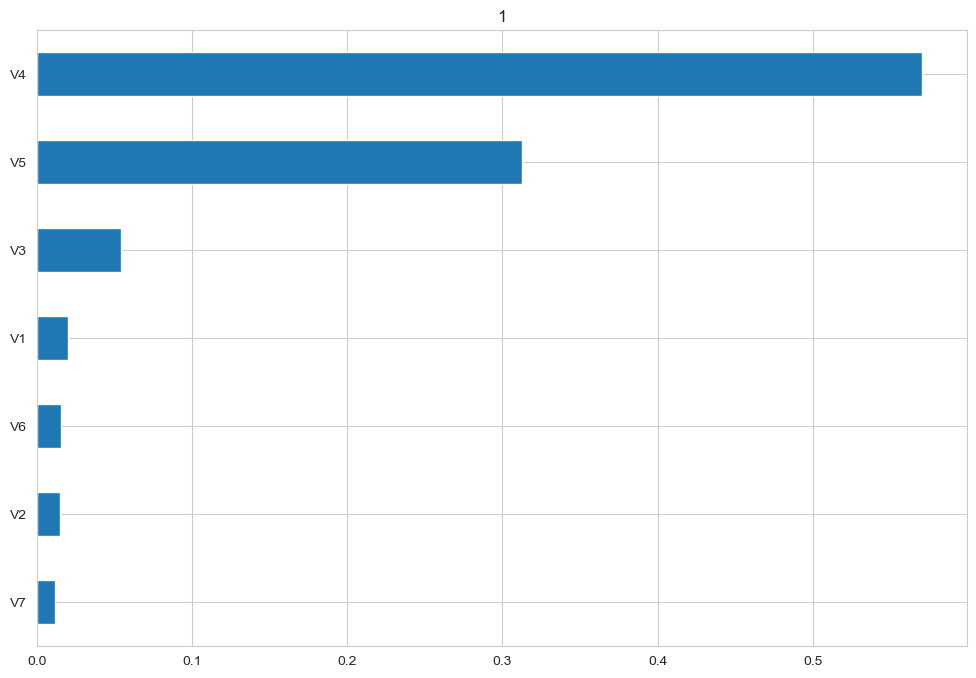

In [323]:
x_learner.plot_importance(X=X_train, tau=xlearner_tau, model_tau_feature=model_tau_feature,
                          normalize=True, method='auto', features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

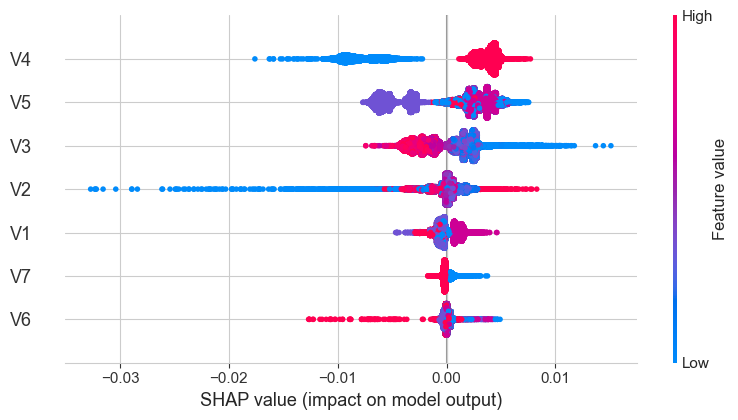

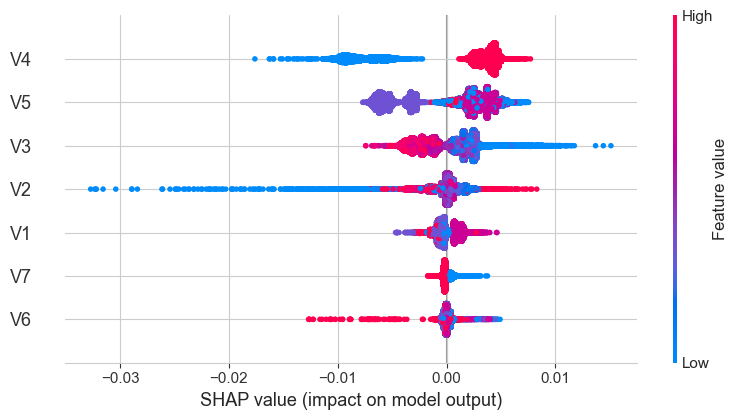

In [325]:
# Compute SHAP values
shap_xlearner = x_learner.get_shap_values(X=X_train, tau=xlearner_tau)

# Plot shap values without specifying shap_dict
x_learner.plot_shap_values(X=X_train, tau=xlearner_tau, features=feature_names)

# Plot shap values WITH specifying shap_dict
x_learner.plot_shap_values(X=X_train, shap_dict=shap_xlearner, features=feature_names)

## Gain Curve

In [202]:
test_data['promotion'] = np.where(test_data['Promotion'] == 'No', 0, 1)

In [396]:
test_data.rename(columns={'tuned_x_learner':'x_learner_tuned'}, inplace=True)

In [404]:
uplift = test_data[['promotion','purchase','s_learner','t_learner','x_learner', 'x_learner_tuned']]

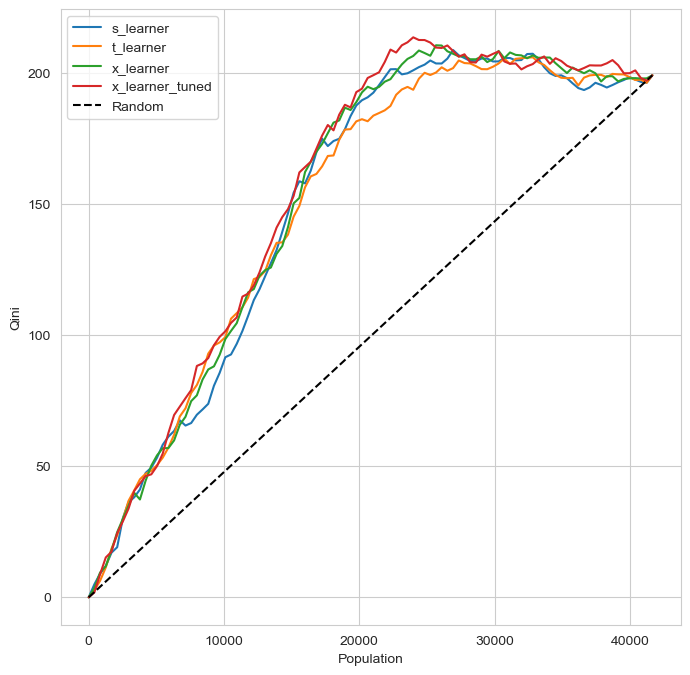

In [405]:
from causalml.metrics import plot_qini, qini_score

# Compare Qini curves
plot_qini(uplift, outcome_col='purchase', treatment_col='promotion')


In [408]:
# GetQini score
qini_score(uplift, outcome_col='purchase', treatment_col='promotion')

s_learner          0.254378
t_learner          0.253547
x_learner          0.266676
x_learner_tuned    0.279369
dtype: float64

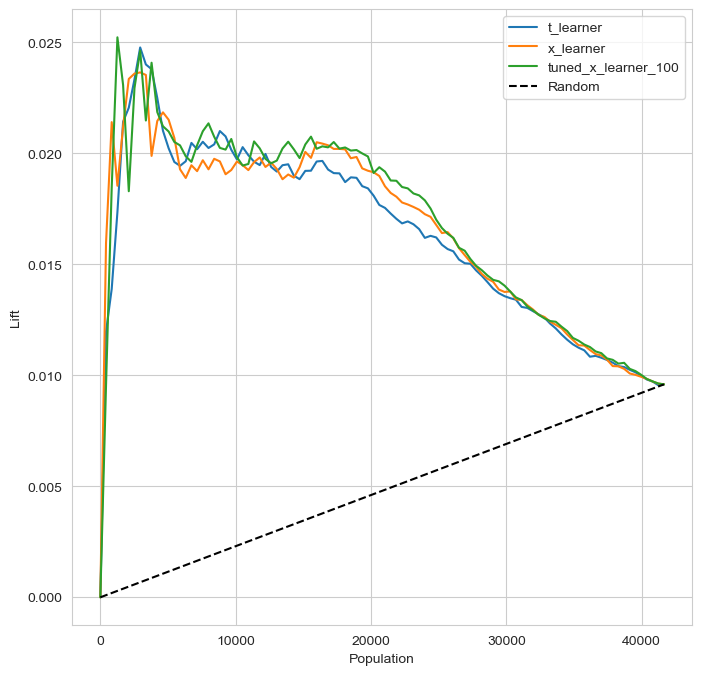

In [388]:
# Compare Qini curves
plot(uplift, outcome_col='purchase', treatment_col='promotion', kind='lift')

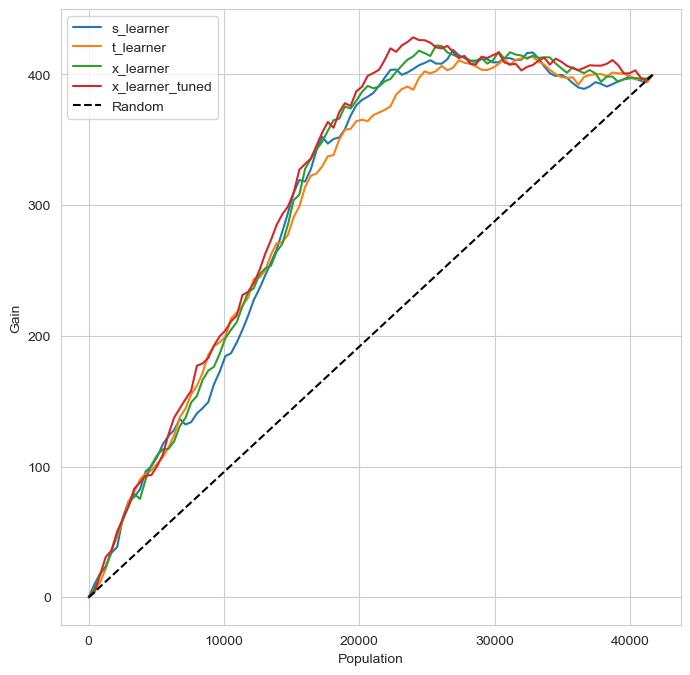

In [406]:
# Compare Qini curves
plot(uplift, outcome_col='purchase', treatment_col='promotion', kind='gain')

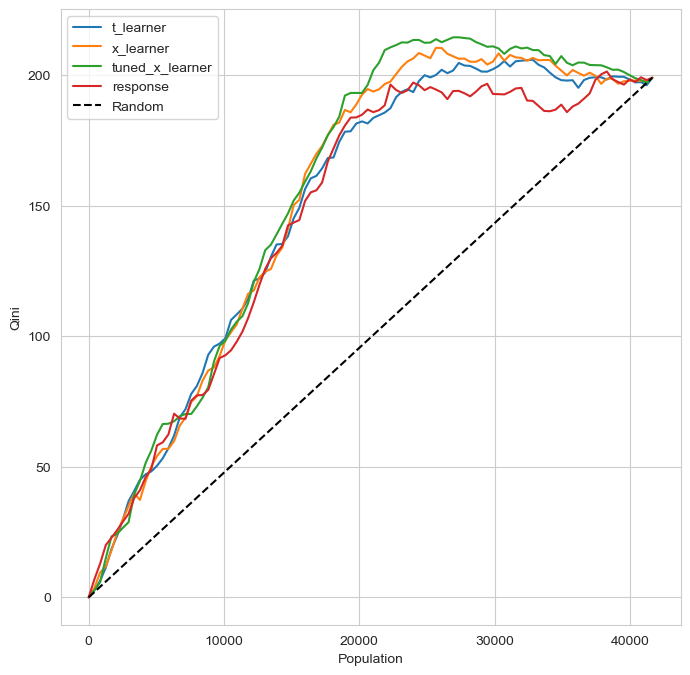

In [333]:
# Compare Qini curves
plot(uplift, outcome_col='purchase', treatment_col='promotion', kind='qini')

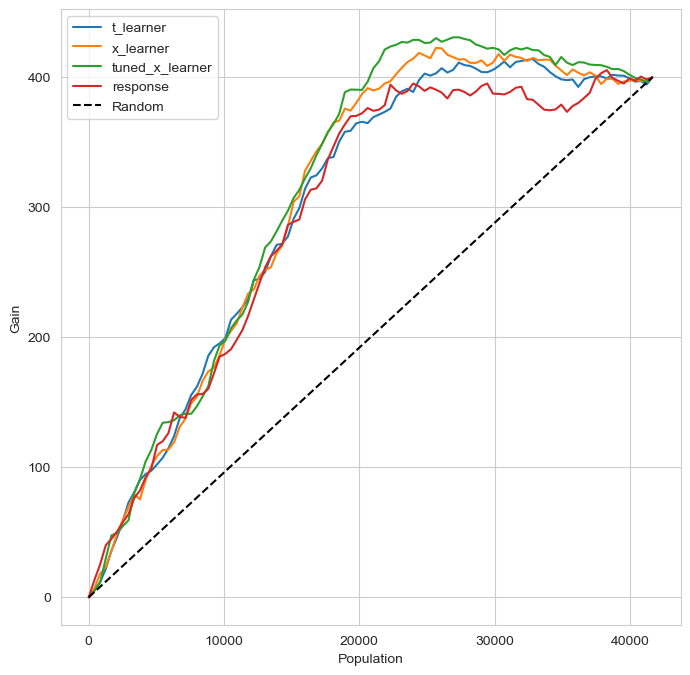

In [334]:
plot_gain(uplift, outcome_col='purchase', treatment_col='promotion')


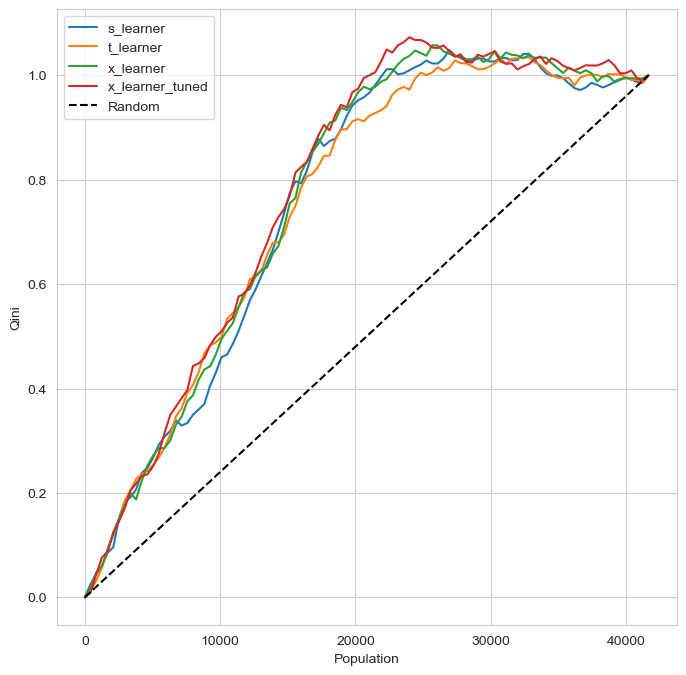

In [407]:
plot_qini(uplift, outcome_col='purchase', treatment_col='promotion', normalize=True)
